<a href="https://colab.research.google.com/github/thach15/Spotify-Project/blob/main/%5BAM115_2024%5D_PSET_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Problem 2

2a

In [1]:
# Imports
import numpy as np
np.random.seed(0)


from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 15})

import scipy

import yfinance as yf
import pandas as pd

In [2]:
# Fetching data for Amazon from 2020-01-01 to 2023-12-31
amazon = yf.Ticker("AMZN")

# Getting historical data
amazon_history = amazon.history(start="2020-01-01", end="2023-12-31")

print(amazon_history.head())  # Displaying the first few rows of data

                                Open       High        Low      Close  \
Date                                                                    
2020-01-02 00:00:00-05:00  93.750000  94.900497  93.207497  94.900497   
2020-01-03 00:00:00-05:00  93.224998  94.309998  93.224998  93.748497   
2020-01-06 00:00:00-05:00  93.000000  95.184502  93.000000  95.143997   
2020-01-07 00:00:00-05:00  95.224998  95.694504  94.601997  95.343002   
2020-01-08 00:00:00-05:00  94.902000  95.550003  94.321999  94.598503   

                             Volume  Dividends  Stock Splits  
Date                                                          
2020-01-02 00:00:00-05:00  80580000        0.0           0.0  
2020-01-03 00:00:00-05:00  75288000        0.0           0.0  
2020-01-06 00:00:00-05:00  81236000        0.0           0.0  
2020-01-07 00:00:00-05:00  80898000        0.0           0.0  
2020-01-08 00:00:00-05:00  70160000        0.0           0.0  


2b

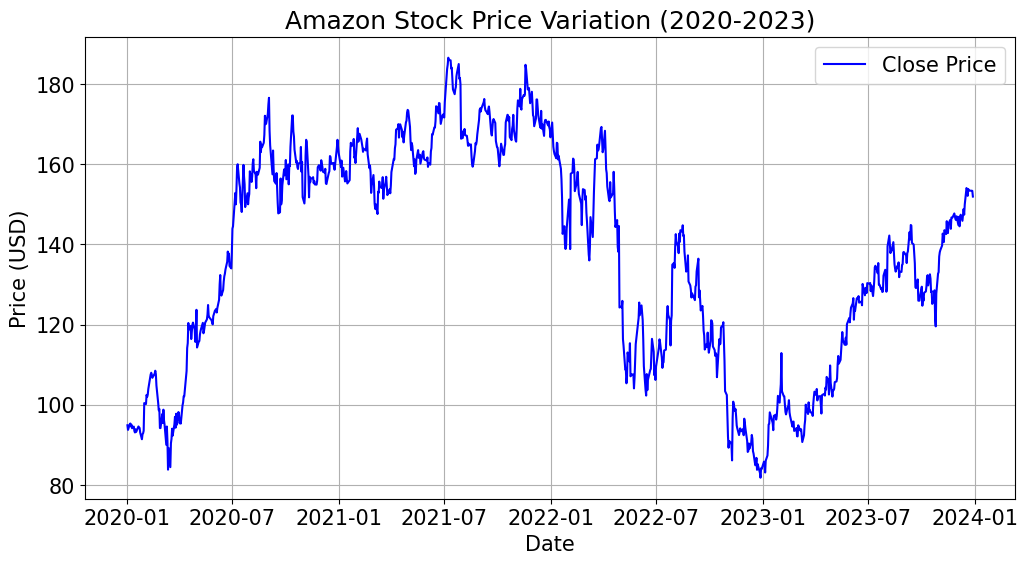

In [3]:
# Plotting the Closing Price over time
plt.figure(figsize=(12, 6))
plt.plot(amazon_history.index, amazon_history['Close'], label='Close Price', color='blue')
plt.title('Amazon Stock Price Variation (2020-2023)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

2c

In [4]:
# Calculate the logarithmic returns
returns = np.log(amazon_history['Close'] / amazon_history['Close'].shift(1))

# Compute the sample mean (μ) and standard deviation (σ) of returns
mu = returns.mean()
sigma = returns.std()

print("Sample mean (μ):", mu)
print("Sample standard deviation (σ):", sigma)

Sample mean (μ): 0.0004683151988553813
Sample standard deviation (σ): 0.023735474128216683


2d

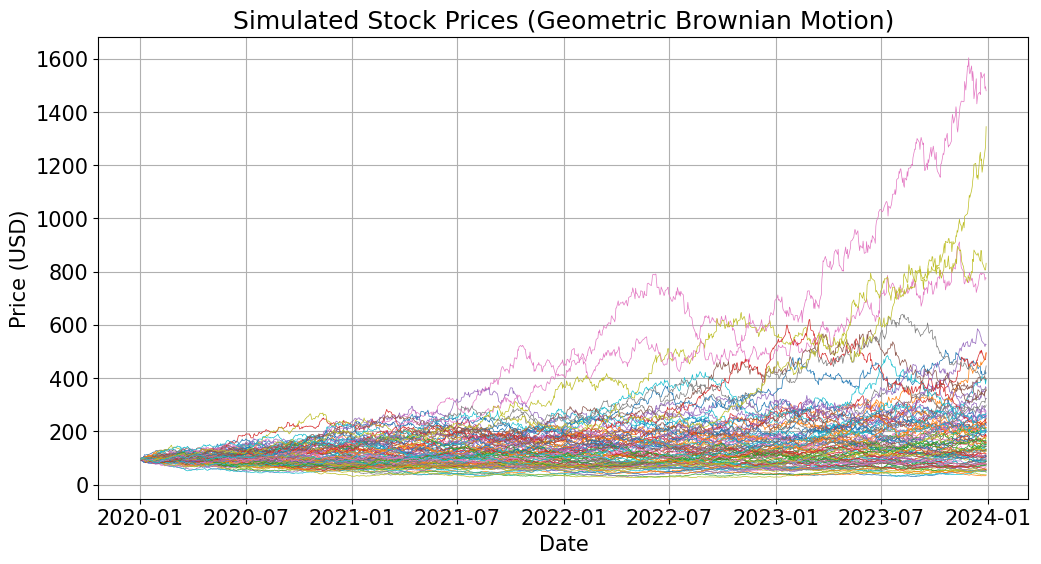

In [5]:
# Define parameters
T = len(amazon_history)  # Number of time steps
N = 100  # Number of simulations
dt = 1  # Time increment (assuming daily data)

# Initialize an array to store simulated stock prices
simulated_prices = np.zeros((T, N))

# Simulate GBM
for i in range(N):
    # Initialize the stock price for each simulation
    S = amazon_history['Close'].iloc[0]
    S_log = [np.log(S)]  # Initial log price

    for t in range(1, T):
        dW = np.sqrt(dt) * np.random.normal(0, 1)  # Brownian motion
        drift = mu * dt
        diffusion = sigma * dW
        d_logS = drift + diffusion  # Change in log price (follows standard Brownian motion)

        S_log.append(S_log[-1] + d_logS)

    simulated_prices[:, i] = np.exp(S_log)

# Plot the simulated stock prices
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(amazon_history.index, simulated_prices[:, i], linewidth=0.5)

plt.title('Simulated Stock Prices (Geometric Brownian Motion)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

2e: Are your plots consistent with the change you observe in the stock price?

Yes, the plots are consistent with the change that I observed in the stock price. We see the fluctuations of the prices overtime and how some are more like outliers than others. However, it is important to know that while this model gives us a good estimate, it fails to take into account other confounding variables such as volatility.

## Problem 3

3a

In [6]:
def monte_carlo_pricing(S0, K, T, r, sigma, n_simulations, n_sim_steps, option_type='call'):

    dt = T / n_sim_steps

    payoffs = []
    for _ in range(n_simulations):

        ### We perform RW in the log space (numerically more stable)
        logS = np.log(S0)
        for _ in range(n_sim_steps):

            Z = np.random.normal(0, 1)
            logS += (r - .5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z

        # convert back to price S
        S = np.exp(logS)

        # payoff at maturity
        if 'call' == option_type:
            payoff = max(0, S - K)

        elif 'put' == option_type:
            payoff = max(0, K - S)

        else:
            raise ValueError('option_type must be "call" or "put"')

        payoffs += [payoff]

    # discount back to present value
    price = np.exp(-r * T) * np.mean(payoffs)

    return price, payoffs

In [7]:
# Define parameters for the Monte Carlo simulation
S0 = amazon_history['Close'].iloc[-1]  # Initial stock price (current price)
K = S0  # Strike price (current price)
T = 1  # Time to expiration (in years), you can adjust as needed
r = 0.05  # Risk-free interest rate
sigma = returns.std()  # Volatility estimated from historical data
n_simulations = 10000  # Number of simulations
n_sim_steps = 252  # Number of time steps (assuming daily data for one year)

# Perform Monte Carlo simulation for call option pricing
option_price, payoffs = monte_carlo_pricing(S0, K, T, r, sigma, n_simulations, n_sim_steps, option_type='call')

print("Monte Carlo Simulation Option Price:", option_price)


Monte Carlo Simulation Option Price: 7.437455728298897


3b

In [8]:
# Function to calculate the Black-Scholes option price
def black_scholes(S, K, T, r, sigma, option_type='call'):
    '''
    S: stock price
    K: strike price
    T: time to maturity in years
    r: risk-free rate
    sigma: volatility of the stock
    option_type: "call" or "put"
    '''

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        option_price = S * scipy.stats.norm.cdf(d1) - K * np.exp(-r * T) * scipy.stats.norm.cdf(d2)

    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * scipy.stats.norm.cdf(-d2) - S * scipy.stats.norm.cdf(-d1)

    return option_price

In [9]:
# Calculate the Black-Scholes price
black_scholes_price = black_scholes(S0, K, T, r, sigma, option_type='call')

print("Black-Scholes Price:", black_scholes_price)

Black-Scholes Price: 7.432542911615172


We see that both the Monte-Carlo and the Black-Scholes results are very similar (the option pricing is around $7.43). However, it is important to note that while Monte-Carlo uses random sampling and assume geometric Brownian motion, Black-Scholes assumes constant voltality and a lognorm distribution of prices. That could explain the differences we see in the option prices they generated.

3c

In [10]:
# Fetching data for Amazon
amazon = yf.Ticker('AMZN')

# Get current stock price
current_price = amazon.history(period='1d')['Close'].iloc[-1]

# Get options data for the nearest expiration date
options_data = amazon.option_chain(amazon.options[0])

calls = options_data.calls
puts = options_data.puts

print(f'Current stock price:\t{current_price}')
print(f'Options maturity date:\t{amazon.options[0]}')

Current stock price:	180.3800048828125
Options maturity date:	2024-03-28


In [11]:
# Define risk-free rate and volatility
risk_free_rate = 0.04
volatility = 0.3

In [12]:
import yfinance as yf
import numpy as np
from scipy.stats import norm
import datetime
import pytz

# Calculate Black-Scholes prices for each option type
def calculate_bs_prices(options_df, option_type):

    now = datetime.datetime.now(pytz.utc)  # make 'now' timezone-aware

    prices = []
    for _, option in options_df.iterrows():

        T = (now - option['lastTradeDate']).days / 365

        bs_price = black_scholes(current_price,
                                 option['strike'],
                                 T,
                                 risk_free_rate,
                                 volatility,
                                 option_type
                                 )

        prices += [bs_price]

    return np.array(prices)

In [13]:
# Calculate Black-Scholes option prices for calls and puts
calls['BS_Price'] = calculate_bs_prices(calls, 'call')
puts['BS_Price'] = calculate_bs_prices(puts, 'put')

# Compare Black-Scholes prices with current option prices
print("Comparison of Black-Scholes Option Prices with Current Option Prices:")
print("Calls:")
print(calls[['contractSymbol', 'lastPrice', 'BS_Price']])
print("\n")
print("Puts:")
print(puts[['contractSymbol', 'lastPrice', 'BS_Price']])

Comparison of Black-Scholes Option Prices with Current Option Prices:
Calls:
         contractSymbol  lastPrice      BS_Price
0   AMZN240328C00085000      96.01  9.538000e+01
1   AMZN240328C00090000      89.73  9.039973e+01
2   AMZN240328C00095000      85.28  8.538000e+01
3   AMZN240328C00100000      79.83  8.038000e+01
4   AMZN240328C00105000      74.87  7.538000e+01
5   AMZN240328C00110000      70.00  7.038000e+01
6   AMZN240328C00115000      65.42  6.538000e+01
7   AMZN240328C00120000      60.37  6.038000e+01
8   AMZN240328C00125000      55.70  5.538000e+01
9   AMZN240328C00130000      50.43  5.038000e+01
10  AMZN240328C00135000      45.48  4.538000e+01
11  AMZN240328C00140000      40.27  4.038000e+01
12  AMZN240328C00145000      35.54  3.538000e+01
13  AMZN240328C00150000      30.32  3.038000e+01
14  AMZN240328C00152500      28.54  2.788000e+01
15  AMZN240328C00155000      25.46  2.538000e+01
16  AMZN240328C00157500      22.68  2.288000e+01
17  AMZN240328C00160000      20.56  2.038

<ipython-input-8-82131601ef17>:12: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
<ipython-input-8-82131601ef17>:12: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


We see that the current stock prices and the black-scholes prices are very similar, giving us confidence in our model.

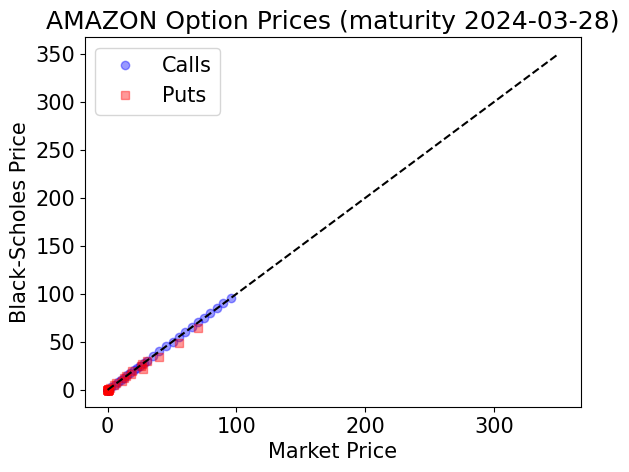

In [14]:
### PLOT PREDICTED VS. MARKET PRICES ###

plt.plot(calls['lastPrice'], calls['BS_Price'], 'bo', alpha=.4, label='Calls')
plt.plot(puts['lastPrice'], puts['BS_Price'], 'rs', alpha=.4, label='Puts')


# Add a line for perfect correlation
x = np.linspace(0, 350, 5)
plt.plot(x, x, 'k--')

# Labels and title
plt.xlabel('Market Price')
plt.ylabel('Black-Scholes Price')

plt.title(f'AMAZON Option Prices (maturity {amazon.options[0]})')

plt.legend();

We see that the option pricings and the Black-Scholes pricing are aligned.

## Problem 4

4a:  *Massachusetts Driving Rules The Massachusetts RMV Driver’s Manual
recommends drivers follow the “two-second rule” to ensure a minimum
safe trailing distance (2018 ed., p. 70). The rule states that a driver should
stay at least “two seconds behind” any vehicle that is directly in front of
their own vehicle. What is the minimal trailing distance and how does it
depend on speed? Translate this into an alternative driving rule stating
how many car lengths a driver should place between the car in front and
the driver’s own car (You’ll need to estimate the average length of a car.).
Is this rule reasonable at extremely low or high speeds?*

The minimal trailing distance ultimately depends on the speed you are traveling at because the faster you are going, the more time you need to allow yourself to safely stop. In this case, the minimal trailing distance would be the speed your going at multiplied by 2 seconds. Let's say the average length of a car is 15 feet. Then the alternative driving rule stating how many car lengths a driver would need to have we use the reaction time and average car length: $\frac{speed * 2 secs}{15 ft}$. In extremely low speeds, the rule is not as relevant as cars are most likely stopping and going. But at extremely high speeds, it is reasonable because the faster cars are going, the more car length distances are needed to be maintained.





4b: *Oscillations in Car Following Model We observed that for our simple
car-following model, oscillations in the lead car results in oscillations in
the follower such that the amplitude could potentially increase. Does the
amplification depend on the lead car’s oscillation frequency? Explain.*

The amplification does depend on the lead car's oscillation frequency. We can show this more concretely by considering the simple car-following model we discussed in class: response = senstivity x stimulus. In this case, the stimulus is the oscillations and the senstivity is how responsive the following car is to these oscillations. We see that if the oscillations of the leading car matches the oscillations of the following car closely, then that means the senstivity is high, leading to a strong response in the following car.  



4c: *Self Driving Cars: How would traffic stability be affected in the age of au-
tonomous vehicles? What assumptions should be reconsidered? In terms
of our simple car-following model, how would the parameters change
qualitatively and how would these changes affect the chance of collisions?
A qualitative answer is sufficient here.*

In the age of autonomous vehicles, we would expect there to be more consistency in the driving behavior as these vehicles are programmed to obey traffic rules and maintain safe distances. Another thing to expect is better reaction times due to the algorithms integreted into the design of the car that influences how quickly the car can respond to unexpected events on the road.

The assumptions that should be reconsidered are then also the reaction time as these vehicles will respond much better and more quickly than humans can and driving behavior due to the heightened consistency we will see in the vehicles on the road.

In terms of our simple car-following model, the sensitivity could be enhanced as the car is designed to react much more efficiently than humans. So we should expect to see less collosions and stronger responses. Furthermore, the stimulus, which is the leading car, will be enhanced as well since the driving behavior of the car will be a lot more predictable.



## Problem 5

5a: The number of cars being conserved means that no cars are being created or destroyed at any given time. The number of cars remain constant. However, a situation when cars are not conserved is when we are on a freeway where cars are randomly entering and exiting the ramp, changing the number of cars.

5b: We did not have to consider the individual car metrics such as space and time because we are modeling traffic on a more macroscopic scale. That is, we consider traffic as a collective where its parameters are density or velocity. A situation where the car velocity
would need to be described in terms of such a dependence is when the roads have construction or tolls as this causes more variance in the space and time the traffic is moving. So to get a more representative model, it should be dependent on these parameters.

5c: The velocity through which disturbances propogate depends on the speed of the car and the density. In the Maha lecture notes, we find that the velocity is determined from the traffic flow equations to solve for an equation for the velocity.

For drivers moving in front of the disturbance, their behaviors are ultimately dependent on what is going on behind the disturbance rather than the disturbance itself. That is, the disturbance can change the traffic flow patterns, causing the drivers in front of it to respond. For example, if the wave decreases in density, that means there is less congestion and they can increase speed.